In this notebook I create a choropleth map that shows how many people responded to the [Stack Overflow Developer Survey 2018](https://insights.stackoverflow.com/survey/2018/) in relation to their countries' populations.

First load the result file into a pandas DataFrame and create a series of value counts from the `Country` column.

In [1]:
%matplotlib inline

import os
import pandas as pd

df_public = pd.read_csv(os.path.expanduser('~/data/kaggle.com/stackoverflow/stack-overflow-2018-developer-survey/survey_results_public.csv'), usecols=['Country'], dtype=str)
df_countries = pd.DataFrame(df_public.Country.value_counts())
df_countries.head(5)

,Country
United States,20309
India,13721
Germany,6459
United Kingdom,6221
Canada,3393


Next create a country index to map the country names used in the developer survey to the [ISO 3166-1](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) country codes that identify countries in the geographic data used later for plotting the map. Then show the names that could not be mapped with the ``iso3166`` package.

In [2]:
from iso3166 import countries

country_index = {name: countries.get(name).alpha3 for name in df_countries.index if name in countries}
set(df_countries.index) - set(country_index)

{'Bolivia',
 'Cape Verde',
 'Congo, Republic of the...',
 'Czech Republic',
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Hong Kong (S.A.R.)',
 'Iran, Islamic Republic of...',
 'Libyan Arab Jamahiriya',
 'Micronesia, Federated States of...',
 'North Korea',
 'Other Country (Not Listed Above)',
 'Republic of Korea',
 'Republic of Moldova',
 'South Korea',
 'The former Yugoslav Republic of Macedonia',
 'United Kingdom',
 'United Republic of Tanzania',
 'Venezuela, Bolivarian Republic of...'}

Add the missing ISO codes manually to the index.

In [3]:
from collections import Counter

country_index.update({
    'Bolivia': 'BOL',
    'Cape Verde': 'CPV',
    'Congo, Republic of the...': 'COG',
    'Czech Republic': 'CZE',
    "Democratic People's Republic of Korea": 'PRK',
    'Democratic Republic of the Congo': 'COD',
    'Hong Kong (S.A.R.)': 'HKG',
    'Iran, Islamic Republic of...': 'IRN',
    'Libyan Arab Jamahiriya': 'LBY',
    'Micronesia, Federated States of...': 'FSM',
    'North Korea': 'PRK',
    'Republic of Korea': 'KOR',
    'Republic of Moldova': 'MDA',
    'South Korea': 'KOR',
    'The former Yugoslav Republic of Macedonia': 'MKD',
    'United Kingdom': 'GBR',
    'United Republic of Tanzania': 'TZA',
    'Venezuela, Bolivarian Republic of...': 'VEN'
})

pd.Series(country_index).value_counts().head()

PRK    2
KOR    2
ISL    1
HRV    1
ECU    1
dtype: int64

In the output above we see, that the two Koreas have two name to ISO code mappings in the index each. So next group by the ``iso`` column, summing up the respondent counts and show the top entries.

In [4]:
df_countries['iso'] = df_countries.index.map(lambda x: country_index.get(x))
iso_index = df_countries.groupby('iso').sum()
iso_index.sort_values('Country', ascending=False).head()

,Country
iso,
USA,20309
IND,13721
DEU,6459
GBR,6221
CAN,3393


In the next cell we import [GeoPandas](http://geopandas.org/), create a GeoDataFrame containing data from [naturalearthdata.com](http://www.naturalearthdata.com/) and remove Antarctica so it doesn't take up unnecessary space. Then add columns containing the total number of respondents per country and the ratio of respondents to 1 million inhabitants.

In [5]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('+proj=robin')
world = world[world.name != 'Antarctica']

world['respondents'] = world['iso_a3'].apply(lambda x: int(iso_index.loc[x]) if x in iso_index.index else None)
world['respondent_ratio'] = world['respondents'] / world['pop_est'] * 1_000_000
world.sort_values('respondent_ratio', ascending=False).head(10)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,respondents,respondent_ratio
77,306694.0,Europe,Iceland,ISL,12710.0,"POLYGON ((-1025302.196888561 6952546.77166883,...",45.0,146.726053
50,1299371.0,Europe,Estonia,EST,27410.0,"POLYGON ((1872088.407724589 6118324.758626858,...",189.0,145.454993
78,7233701.0,Asia,Israel,ISR,201400.0,"POLYGON ((3209703.584131608 3498387.789316183,...",1003.0,138.656547
28,7604467.0,Europe,Switzerland,CHE,316700.0,"POLYGON ((799805.1118756525 5069666.509551148,...",1010.0,132.816672
120,4213418.0,Oceania,New Zealand,NZL,116700.0,(POLYGON ((14993207.4601813 -4373933.456521292...,557.0,132.196711
74,4203200.0,Europe,Ireland,IRL,188400.0,POLYGON ((-493519.5353766397 5723612.199234703...,554.0,131.804340
151,9059651.0,Europe,Sweden,SWE,344300.0,"POLYGON ((1580026.141474696 6884344.137279728,...",1164.0,128.481770
118,4676305.0,Europe,Norway,NOR,276400.0,(POLYGON ((1885031.797202721 7380292.033532551...,565.0,120.821888
97,491775.0,Europe,Luxembourg,LUX,39370.0,"POLYGON ((495064.0699557118 5340139.039437959,...",59.0,119.973565
43,5500510.0,Europe,Denmark,DNK,203600.0,(POLYGON ((995956.0168443418 5899888.876027877...,653.0,118.716264


Now plot the map. We treat countries with and without data separately, add annotations and a legend, so the graphic can be interpreted without additional context.  See this notebook on [creating choropleth maps with GeoPandas](http://ramiro.org/notebook/geopandas-choropleth/) for more details.

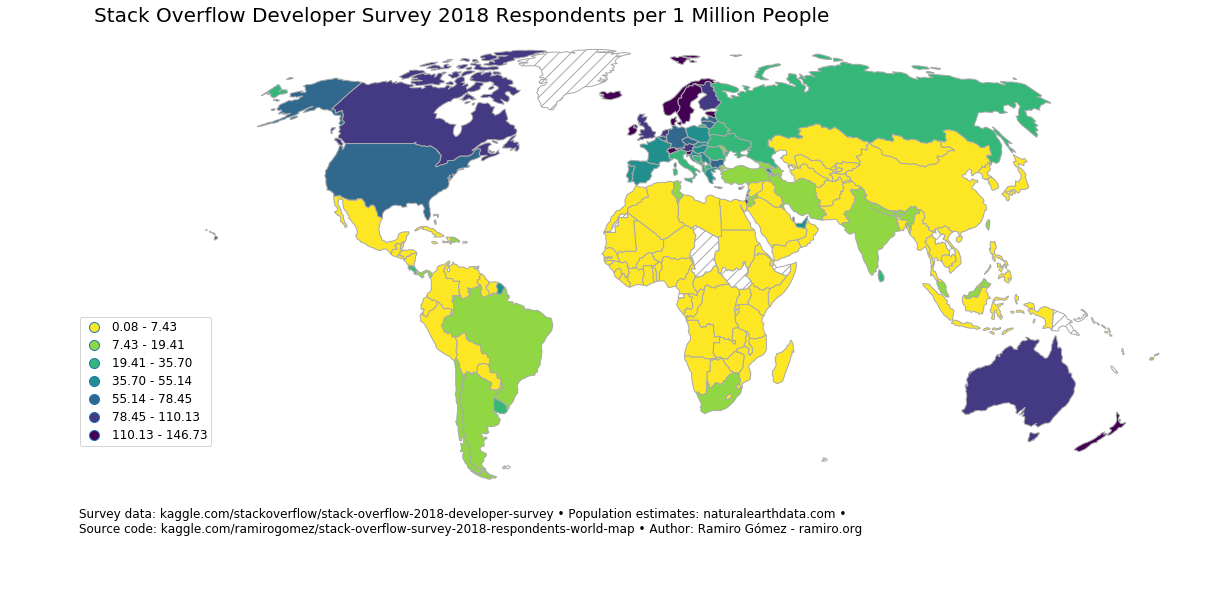

In [6]:
known = world.dropna(subset=['respondent_ratio'])
unknown = world[world['respondent_ratio'].isna()]

ax = known.plot(column='respondent_ratio', cmap='viridis_r', figsize=(20, 12), scheme='fisher_jenks', k=7, legend=True, edgecolor='#aaaaaa')
unknown.plot(ax=ax, color='#ffffff', hatch='//', edgecolor='#aaaaaa')

ax.set_title('Stack Overflow Developer Survey 2018 Respondents per 1 Million People', fontdict={'fontsize': 20}, loc='left')
descripton = '''
Survey data: kaggle.com/stackoverflow/stack-overflow-2018-developer-survey • Population estimates: naturalearthdata.com • 
Source code: kaggle.com/ramirogomez/stack-overflow-survey-2018-respondents-world-map • Author: Ramiro Gómez - ramiro.org'''.strip()
ax.annotate(descripton, xy=(0.065, 0.12), size=12, xycoords='figure fraction')

ax.set_axis_off()
legend = ax.get_legend()
legend.set_bbox_to_anchor((.11, .4))
legend.prop.set_size(12)

## Conclusion

While the USA is by far the country with the most respondents, we see that Iceland, Estonia, Israel, Switzerland and New Zealand have the highest ratios of developer survey respondents in relation to population. A map just showing the total numbers would certainly look very different and tell a different story.

In [7]:
%load_ext signature
%signature